IF YOU WANT TO RUN IT IN TEOGPU (SUGGESTED) VIA VSCODE use "amilici_exam" conda environment as jupyter kernel. 

IF YOU WANT TO RUN IT IN GOOGLE COLAB YOU SHOULD DOWNLOAD THE PROJECT IN YOUR OWN DRIVE AND THEN USE THE FOLLOWING LINES AND MAKE SURE TO SET GPU T4 RUNTIME:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import sys 
#sys.path.append('/content/drive/MyDrive/ml_exam/quench_project') #YOUR PATH TO THE PROJECT IN GOOGLE DRIVE
#%cd /content/drive/MyDrive/ml_exam/quench_project 
#!pwd
#file = '' # YOUR PATH TO THE FILE IN GOOGLE DRIVE


"\nfrom google.colab import drive\ndrive.mount('/content/drive')\nimport sys \nsys.path.append('/content/drive/MyDrive/ml_exam/quench_project')\n%cd /content/drive/MyDrive/ml_exam/quench_project\n!pwd\nfile = '' #path for quench dataset in google drive\n"

# Task 2: Quench Count Estimation via Multi-class Classification

### Problem Statement

The goal of this task is to estimate the number of quenches occurring within sequences that have already been classified as positive (i.e., containing at least one quench).

- **Input:** Sequences of heat maps labeled as containing quench(es).
- **Output:** A prediction of the exact number of quenches present in the sequence.

### Approach

This problem can be formulated as a **multi-class classification** task, where each class corresponds to a possible number of quenches (e.g., 1, 2, 3, ...). The model will learn to distinguish sequences based on how many distinct quench events they contain.

Using a multi-class classifier simplifies the prediction problem by directly assigning the sequence to one of the discrete count classes, rather than treating it as a regression problem.

---


In [11]:
from data.QuenchDataLoader import QuenchDataLoader
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd

from utils.model_utils import count_parameters,reset_weights
from utils.seed import set_seed
set_seed(42)

Loading the dataset, by default converted in (N,24,15,15). Dataloader.get_data() returns a pandas dataframe with columns from the original dataset plus another one containing the number of quenches per sequence

In [12]:
file = "/auto_atlas/atlas/atlas_gen_fs/amilici/other_samples/ml_exam_dataset/data_quench.json"
dataloader = QuenchDataLoader(file) # transform_to_2d= True di default
data= dataloader.get_data()

# Taking only quenched sequences
data = data[data.label == 1].reset_index()

print(f"Dataset size: {len(data)}")
print(f"Dataset columns: {data.columns}")
data.head()

Dataset size: 300
Dataset columns: Index(['index', 'sequence', 'label', 'quench', 'num_quench'], dtype='object')


,index,sequence,label,quench,num_quench
0,8,"[[[22.582478486789327, 22.904808739314365, 22....",1,"[{'step': 18, 'pixel': [2, 1], 'temp': 25.1909...",1.0
1,9,"[[[22.0373877189044, 18.636944579237863, 21.76...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 25.0312...",7.0
2,20,"[[[21.411886934355916, 23.16618378647687, 20.1...",1,"[{'step': 14, 'pixel': [7, 7], 'temp': 24.8999...",1.0
3,21,"[[[21.276068279076245, 20.97700816985905, 21.2...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 24.4713...",2.0
4,23,"[[[21.69330864976891, 19.39115826850467, 20.55...",1,"[{'step': 15, 'pixel': [10, 13], 'temp': 25.69...",1.0


### Data preprocessing : min-max scaling

In [13]:
#Preprocessing: Normalizzazione dei dati
# Trova min e max globali su tutto il dataset

all_values = np.concatenate([sequence.flatten() for sequence in data.sequence])
global_min = np.min(all_values)
global_max = np.max(all_values)
denom = global_max - global_min
data.sequence = (data.sequence- global_min)/denom

def power_transform(sequence, power=2):
    return sequence ** power

# Applica la trasformazione di potenza
#data.sequence = data.sequence.apply(lambda x: power_transform(x,power=3))


# Data Augmentation

To increase the size and diversity of the training data, we apply several augmentation operations on the heat map sequences. This helps improve model robustness and generalization.

### Augmentation operations used:
- Rotations: 90°, 180°, 270°
- Flips: horizontal, vertical, diagonal (secondary)
- Time reversal (reversing sequence order)
- Combined reverse and flip
- Transpose spatial grid
- Adding Gaussian noise
- Shuffling time steps



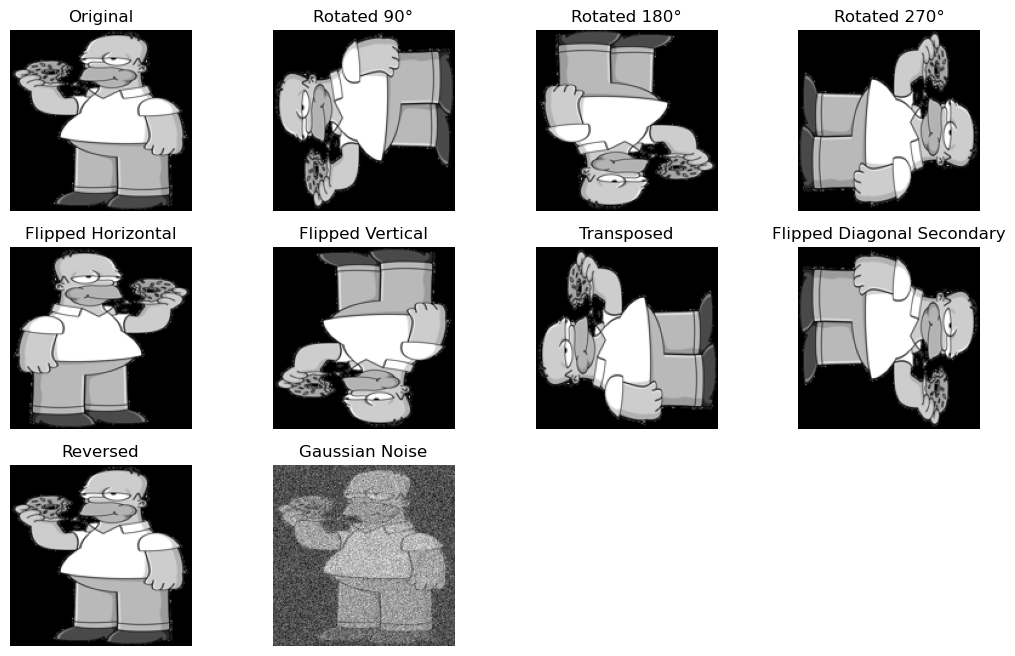

In [14]:
from data.augmentation import *
# esempio d'uso:
from PIL import Image
img_original = Image.open('homer.png')
img_small = np.array(img_original.convert('L').resize((150, 150)))

seq =img_small.reshape(1, 150, 150)  # Aggiungo la dimensione batch
seq_rot_90 = rotate_90(seq)
seq_rotate_270 = rotate_270(seq)
seq_rotate_180 = rotate_180(seq)

seq_flip_horizontal = flip_horizontal(seq)
seq_flip_vertical = flip_vertical(seq)
seq_transpose = transpose(seq)
seq_flip_diagonal_secondary = flip_diagonal_secondary(seq)

seq_noise = add_gaussian_noise(seq, mean=seq.mean(), std=50)
seq_reverse = time_reversal(seq)




plt.figure(figsize=(13, 8))
# Prima riga: 3 immagini
plt.subplot(3, 4, 1)
plt.imshow(seq[0], cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(3, 4, 2)
plt.imshow(seq_rot_90[0], cmap='gray')
plt.axis('off')
plt.title('Rotated 90°')


plt.subplot(3, 4, 3)
plt.imshow(seq_rotate_180[0], cmap='gray')
plt.axis('off')
plt.title('Rotated 180°')

plt.subplot(3, 4, 4)
plt.imshow(seq_rotate_270[0], cmap='gray')
plt.axis('off')
plt.title('Rotated 270°')

plt.subplot(3, 4, 5)
plt.imshow(seq_flip_horizontal[0], cmap='gray')
plt.axis('off')
plt.title('Flipped Horizontal')

plt.subplot(3, 4, 6)
plt.imshow(seq_flip_vertical[0], cmap='gray')
plt.axis('off')
plt.title('Flipped Vertical')

plt.subplot(3, 4, 7)
plt.imshow(seq_transpose[0], cmap='gray')
plt.axis('off')
plt.title('Transposed')

plt.subplot(3, 4, 8)
plt.imshow(seq_flip_diagonal_secondary[0], cmap='gray')
plt.axis('off')
plt.title('Flipped Diagonal Secondary')

plt.subplot(3, 4, 9)
plt.imshow(seq_reverse[0], cmap='gray')
plt.axis('off')
plt.title('Reversed')


plt.subplot(3, 4, 10)
plt.imshow(seq_noise[0], cmap='gray')
plt.axis('off')
plt.title('Gaussian Noise')

plt.show()


In [15]:
# Adding a column to distinguish augmented data from original data
data['augmented']= False
data.head()

,index,sequence,label,quench,num_quench,augmented
0,8,"[[[0.5438055558241474, 0.5755248699113726, 0.4...",1,"[{'step': 18, 'pixel': [2, 1], 'temp': 25.1909...",1.0,False
1,9,"[[[0.49016521292383064, 0.15554032699428255, 0...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 25.0312...",7.0,False
2,20,"[[[0.42861202115397634, 0.6012458103150874, 0....",1,"[{'step': 14, 'pixel': [7, 7], 'temp': 24.8999...",1.0,False
3,21,"[[[0.41524661548084363, 0.38581722912660055, 0...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 24.4713...",2.0,False
4,23,"[[[0.456305679171562, 0.22975967411212875, 0.3...",1,"[{'step': 15, 'pixel': [10, 13], 'temp': 25.69...",1.0,False


In [16]:
operations = [rotate_90, rotate_180,rotate_270, flip_horizontal, 
              flip_vertical, time_reversal,reverse_and_flip,add_gaussian_noise,
              transpose,flip_diagonal_secondary,shuffle]

def data_augmentation(data, operations):
    all_datasets= [data]
    for op in operations:
        op_data = pd.DataFrame({
        'sequence': [op(seq) for seq in data.sequence],
        'label': data.label,
        'quench': data.quench,
        'num_quench': data.num_quench,
        'augmented': True   
        })
        all_datasets.append(op_data)
    augmented_data = pd.concat(all_datasets, ignore_index=True) 
    return augmented_data.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

In [17]:
augmented_data = data_augmentation(data, operations)
print(f"Augmented dataset size: {len(augmented_data)}")

Augmented dataset size: 3600


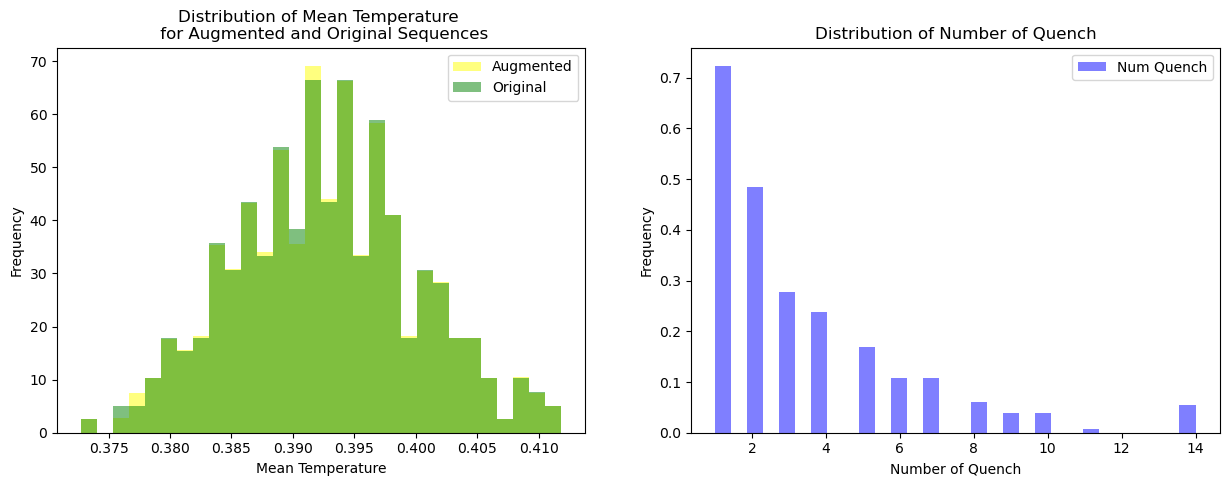

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Estrai sequenze aumentate e non aumentate come liste
seq_aug = augmented_data[augmented_data['augmented'] == True]['sequence'].tolist()
seq_orig = augmented_data[augmented_data['augmented'] == False]['sequence'].tolist()

# Converti in array 4D
seq_aug_array = np.array(seq_aug)   # shape (N_aug, 24, 15, 15)
seq_orig_array = np.array(seq_orig) # shape (N_orig, 24, 15, 15)

# Calcola media temperatura totale per ogni sequenza
mean_aug = seq_aug_array.mean(axis=(1,2,3))
mean_orig = seq_orig_array.mean(axis=(1,2,3))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_aug, bins=30, alpha=0.5, label='Augmented', color='yellow',density=True)
plt.hist(mean_orig, bins=30, alpha=0.5, label='Original', color='green',density=True)   
plt.xlabel('Mean Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Temperature \n for Augmented and Original Sequences')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(augmented_data['num_quench'], bins=30, alpha=0.5, label='Num Quench', color='blue', density=True)
plt.xlabel('Number of Quench')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Quench')
plt.legend()
plt.show()


In [19]:
from data.torch_Dataset import torch_Dataset_task2
dataset = torch_Dataset_task2(augmented_data)

# Train, validation, and test split

train_size = int(0.85 * len(dataset))
val_size= int(0.075 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")



Training set size: 3060
Validation set size: 270
Test set size: 270


# 📋 Model Summary — DeepCNN3D

**Input shape:** `(batch_size, 1, 24, 15, 15)`  
**Output shape:** `(batch_size, 14)`  
**Total parameters:** `120,846`  
**Trainable parameters:** `120,846`  

---

### 🔍 Layer-wise structure:

| Layer (type)         | Output Shape         | Param # |
|----------------------|----------------------|---------|
| Conv3d (1→32)        | (32, 24, 15, 15)     | 896     |
| ReLU                 | (32, 24, 15, 15)     | 0       |
| BatchNorm3d          | (32, 24, 15, 15)     | 64      |
| MaxPool3d            | (32, 12, 7, 7)       | 0       |
|                      |                      |         |
| Conv3d (32→64)       | (64, 12, 7, 7)       | 55,360  |
| BatchNorm3d          | (64, 12, 7, 7)       | 128     |
| ReLU                 | (64, 12, 7, 7)       | 0       |
| MaxPool3d            | (64, 6, 3, 3)        | 0       |
|                      |                      |         |
| Conv3d (64→128)      | (128, 6, 3, 3)       | 221,312 |
| Dropout (p=0.5)      | (128, 6, 3, 3)       | 0       |
| ReLU                 | (128, 6, 3, 3)       | 0       |
| MaxPool3d            | (128, 3, 1, 1)       | 0       |
|                      |                      |         |
| Flatten              | (384,)               | 0       |
| Linear (384→256)     | (256,)               | 98,560  |
| ReLU                 | (256,)               | 0       |
| Linear (256→32)      | (32,)                | 8,224   |
| ReLU                 | (32,)                | 0       |
| Linear (32→16)       | (16,)                | 528     |
| ReLU                 | (16,)                | 0       |
| Linear (16→14)       | (14,)                | 238     |

---

### ✅ Output: 14 class logits


##  Loss Function, Optimizer, and Learning Rate Scheduler

### 🎯 `nn.CrossEntropyLoss(weight=class_weights)`
The loss function used is `CrossEntropyLoss`, which is well-suited for **multi-class classification problems**. It internally applies a `LogSoftmax` followed by a `Negative Log-Likelihood`, returning a scalar loss that measures the distance between the predicted logits and the true class labels.

- `weight=class_weights`: this is used to **handle class imbalance**. Less frequent classes are given higher weights to prevent the model from ignoring them during training.
- The `class_weights` tensor should have shape `(num_classes,)` and must be moved to the same `device` as the model.

---



### 📉 `torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)`
A **learning rate scheduler** is used to reduce the learning rate during training:

- `step_size=100`: every 100 epochs (or steps, depending on how it's called), the scheduler updates the learning rate.
- `gamma=0.1`: the learning rate is multiplied by this factor, effectively reducing it by 90%.

This helps the model **converge better** by taking smaller steps as it gets closer to a minimum.


In [20]:
from models.DeepCNN3D import DeepCNN3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN3D(num_classes=14).to(device)

from utils.class_weights import get_class_weights

class_weights = get_class_weights(train_dataset)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

Class weights: tensor([ 1.0000,  1.4799,  2.6131,  2.9508,  4.4398,  6.5685,  6.9493, 11.5542,
        20.4043, 19.5714, 87.1818,  0.0000,  0.0000, 13.5070])


In [21]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    correct = 0
   
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).long() - 1  # se label da 1 a 14, porto a 0-13
      
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()
        
        
        train_loss += loss.item() 
        _, predicted = nn.Softmax(dim=1)(outputs).max(1)
        correct += (predicted==labels.squeeze().long()).sum().item()
        
    epoch_loss = train_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long() - 1
          
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze().long())
            
            val_loss += loss.item()
           
            _,predicted = nn.Softmax(dim=1)(outputs).max(1)
            correct+= (predicted==labels.squeeze().long()).sum().item()
            
            
    epoch_loss = val_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc


In [22]:
num_epochs = 300
val_losses = []
train_losses = []
val_accs = []
train_accs = []
for epoch in range(num_epochs):

    if epoch == 0:
        reset_weights(model)  # Reset weights at the beginning of each epoch

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()  # Update learning rate
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    train_accs.append(train_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Train acc: {100*train_acc:.4f}%| Val acc: {100*val_acc:.4f}%")

Epoch 1/300
Train loss: 0.0806 | Val loss: 0.0841 | Train acc: 7.5490%| Val acc: 15.1852%
Epoch 2/300
Train loss: 0.0703 | Val loss: 0.0742 | Train acc: 31.3399%| Val acc: 15.5556%
Epoch 3/300
Train loss: 0.0612 | Val loss: 0.0623 | Train acc: 32.9085%| Val acc: 41.4815%
Epoch 4/300
Train loss: 0.0580 | Val loss: 0.0612 | Train acc: 34.4118%| Val acc: 31.1111%
Epoch 5/300
Train loss: 0.0546 | Val loss: 0.0600 | Train acc: 37.8105%| Val acc: 44.8148%
Epoch 6/300
Train loss: 0.0514 | Val loss: 0.0610 | Train acc: 41.2092%| Val acc: 45.5556%
Epoch 7/300
Train loss: 0.0487 | Val loss: 0.0953 | Train acc: 40.8170%| Val acc: 33.3333%
Epoch 8/300
Train loss: 0.0473 | Val loss: 0.0540 | Train acc: 45.6863%| Val acc: 50.0000%
Epoch 9/300
Train loss: 0.0430 | Val loss: 0.0589 | Train acc: 47.5817%| Val acc: 27.0370%
Epoch 10/300
Train loss: 0.0416 | Val loss: 0.0530 | Train acc: 49.5752%| Val acc: 49.2593%
Epoch 11/300
Train loss: 0.0382 | Val loss: 0.1337 | Train acc: 53.6601%| Val acc: 3.7037%

Epoch 14/300
Train loss: 0.0345 | Val loss: 0.0422 | Train acc: 57.3856%| Val acc: 55.9259%
Epoch 15/300
Train loss: 0.0313 | Val loss: 0.0510 | Train acc: 60.4902%| Val acc: 53.3333%
Epoch 16/300
Train loss: 0.0343 | Val loss: 0.0525 | Train acc: 55.8497%| Val acc: 38.5185%
Epoch 17/300
Train loss: 0.0291 | Val loss: 0.0561 | Train acc: 61.7647%| Val acc: 56.2963%
Epoch 18/300
Train loss: 0.0268 | Val loss: 0.0470 | Train acc: 61.8627%| Val acc: 59.2593%
Epoch 19/300
Train loss: 0.0280 | Val loss: 0.0334 | Train acc: 63.6275%| Val acc: 57.4074%
Epoch 20/300
Train loss: 0.0248 | Val loss: 0.0386 | Train acc: 65.5229%| Val acc: 40.3704%
Epoch 21/300
Train loss: 0.0232 | Val loss: 0.0537 | Train acc: 67.4837%| Val acc: 33.7037%
Epoch 22/300
Train loss: 0.0224 | Val loss: 0.0541 | Train acc: 67.5817%| Val acc: 26.6667%
Epoch 23/300
Train loss: 0.0221 | Val loss: 0.0321 | Train acc: 68.0719%| Val acc: 67.0370%
Epoch 24/300
Train loss: 0.0208 | Val loss: 0.0283 | Train acc: 70.2614%| Val ac

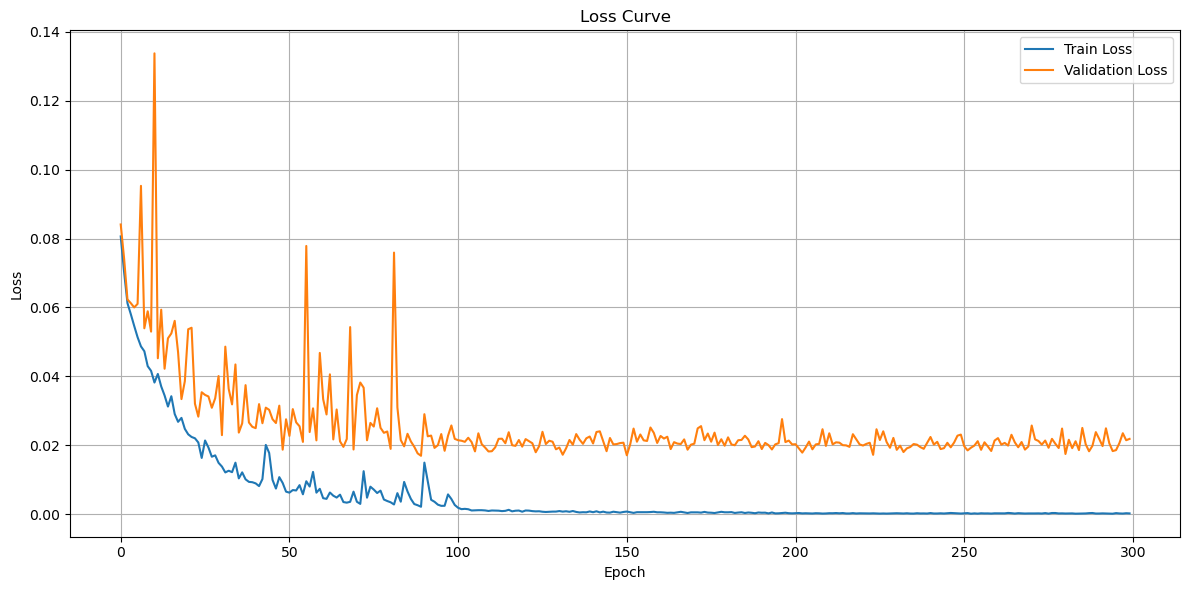

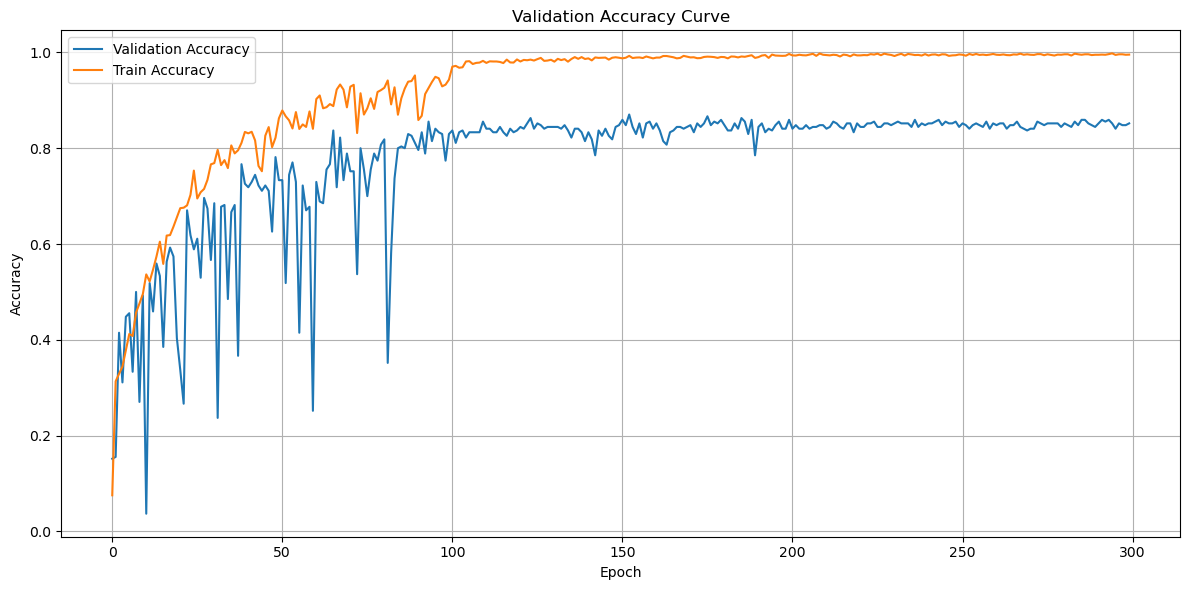

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.grid()
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(val_accs, label='Validation Accuracy')
plt.plot(train_accs, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Validation Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()


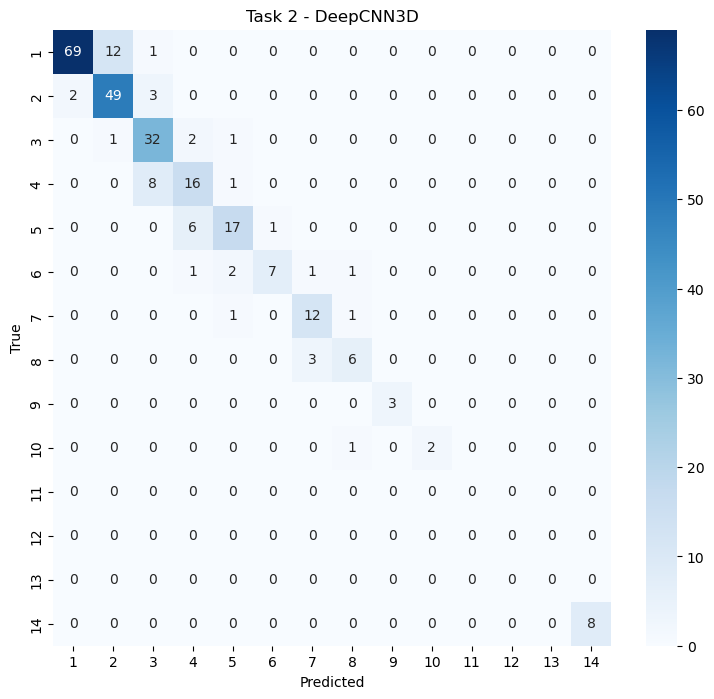

In [25]:
# test performance and confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def test_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long() - 1
            
            outputs = model(inputs)
            _, predicted = nn.Softmax(dim=1)(outputs).max(1)
            
            all_labels.extend(labels.squeeze().long().cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

all_labels, all_preds = test_model(model, test_loader, device)
all_labels = all_labels + 1  # Convert back to original labels (1-14)
all_preds = all_preds + 1  # Convert back to original labels (1-14)

from utils.plot import plot_confusion_matrix
fig=plot_confusion_matrix(all_labels, all_preds, classes=list(range(1, 15)),title='Task 2 - DeepCNN3D')
fig.savefig("plots/task2/confusion_matrix_DeepCNN3D.png", dpi=300, bbox_inches='tight')



In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Accuracy generale
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.2f}")

# Precision, Recall, F1 - macro-average (tutte le classi uguale peso)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print(f"Precision (macro): {precision_macro:.2f}")
print(f"Recall (macro): {recall_macro:.2f}")
print(f"F1-score (macro): {f1_macro:.2f}")

# Genera report come dizionario
report_dict = classification_report(all_labels, all_preds, output_dict=True)

# Converti in DataFrame e togli la riga 'accuracy' (non è per classe)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_json("reports/task2/multiclass_report_task2.json", orient='records', indent=4)


# Mostra la tabella in Jupyter (automaticamente formattata in HTML)
df_report

Accuracy: 0.82
Precision (macro): 0.84
Recall (macro): 0.80
F1-score (macro): 0.81


,precision,recall,f1-score,support
1,0.971831,0.841463,0.901961,82.000000
2,0.790323,0.907407,0.844828,54.000000
3,0.727273,0.888889,0.800000,36.000000
4,0.640000,0.640000,0.640000,25.000000
5,0.772727,0.708333,0.739130,24.000000
6,0.875000,0.583333,0.700000,12.000000
7,0.750000,0.857143,0.800000,14.000000
8,0.666667,0.666667,0.666667,9.000000
9,1.000000,1.000000,1.000000,3.000000
10,1.000000,0.666667,0.800000,3.000000
